# A.1: Download the data

In [2]:
from fastai.vision.all import *
from fastai.metrics import accuracy, error_rate, Precision, Recall, F1Score, BalancedAccuracy
from pathlib import Path
from IPython.display import display, Image
import os
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
!unzip "/content/drive/MyDrive/ADA 447/Dataset/car.zip" -d "/content"

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: /content/car/train/labels/00000_00003_00023_png.rf.d380a41c490b666ce4bee8990368a1fd.txt  
  inflating: /content/car/train/labels/00000_00003_00024_png.rf.08957035e670072dbb22d8f9905e9b84.txt  
  inflating: /content/car/train/labels/00000_00003_00025_png.rf.11e558fae394d310693ee9223b8962ca.txt  
  inflating: /content/car/train/labels/00000_00003_00026_png.rf.1f6b33373353f896f2c2025ffd264e51.txt  
  inflating: /content/car/train/labels/00000_00003_00026_png.rf.a3b6c2dcd4ee9a8064667b7bb266590b.txt  
  inflating: /content/car/train/labels/00000_00003_00027_png.rf.c1381ed46ee0d7e21877ea3d7ef86127.txt  
  inflating: /content/car/train/labels/00000_00003_00029_png.rf.8e24d2606537779612888c6a06c7043d.txt  
  inflating: /content/car/train/labels/00000_00004_00000_png.rf.45dccdbf08ed12f25d7742d8bf88c102.txt  
  inflating: /content/car/train/labels/00000_00004_00001_png.rf.557d3494b3e633e29069a6f42918334e.txt  
  inflating: /content/car/

In [20]:
import shutil

# Class label mapping
classes_dict = {
    0: 'Green Light',
    1: 'Red Light',
    2: 'Speed Limit 10',
    3: 'Speed Limit 100',
    4: 'Speed Limit 110',
    5: 'Speed Limit 120',
    6: 'Speed Limit 20',
    7: 'Speed Limit 30',
    8: 'Speed Limit 40',
    9: 'Speed Limit 50',
    10: 'Speed Limit 60',
    11: 'Speed Limit 70',
    12: 'Speed Limit 80',
    13: 'Speed Limit 90',
    14: 'Stop',
    15: 'No Traffic Sign'
}

base_path = Path("/content/car")
dest_path = Path("/content/car/data")

for split in ['train', 'valid', 'test']:
    images_path = base_path / split / 'images'
    labels_path = base_path / split / 'labels'

    for img_file in images_path.glob("*.jpg"):
        label_file = labels_path / (img_file.stem + ".txt")
        if not label_file.exists():
            print(f"Missing label for {img_file.name}, skipping.")
            continue
        label_content = label_file.read_text().strip()
        if not label_content or not label_content.split():
            print(f"Empty or malformed label in {label_file.name}, skipping.")
            continue
        try:
            label_index = int(label_content.split()[0])
            class_name = classes_dict[label_index]
        except (ValueError, IndexError, KeyError):
            print(f"Invalid label index in {label_file.name}: '{label_content}', skipping.")
            continue
        class_folder = dest_path / class_name
        class_folder.mkdir(parents=True, exist_ok=True)
        new_filename = f"{split}_{img_file.name}"
        shutil.copy(img_file, class_folder / new_filename)

Empty or malformed label in FisheyeCamera_1_00807_png.rf.065f778b2eaf15dd7b5beb90b30c490c.txt, skipping.
Empty or malformed label in FisheyeCamera_1_00926_png.rf.511cfac04ff48a1fe99b560b4a4fb9e2.txt, skipping.
Empty or malformed label in FisheyeCamera_1_00802_png.rf.6a502d781364b74f35bfa71832fc1ede.txt, skipping.
Empty or malformed label in FisheyeCamera_1_00922_png.rf.408835a278b9c700eb1a2f358ca58d07.txt, skipping.


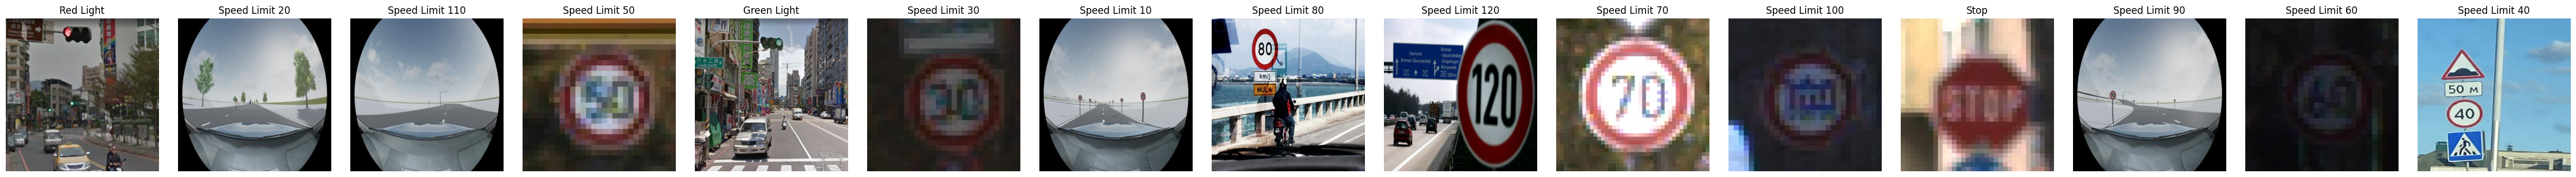

In [21]:
path = Path("/content/car/data")

class_dirs = [d for d in path.iterdir() if d.is_dir()]
non_empty_dirs = [d for d in class_dirs if len(get_image_files(d)) > 0]
n = len(non_empty_dirs)
fig, axs = plt.subplots(1, n, figsize=(3*n, 3))
for ax, class_dir in zip(axs, non_empty_dirs):
    img_path = get_image_files(class_dir)[0]
    img = PILImage.create(img_path)
    ax.imshow(img)
    ax.set_title(class_dir.name)
    ax.axis('off')

plt.tight_layout()
plt.show()

# A.2: Create the DataBlock and DataLoaders

In [22]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct= 0.2, seed= 42),
    get_y=parent_label,
    item_tfms=Resize(224),
    batch_tfms=[*aug_transforms(size=224)]
)

dls = dblock.dataloaders(path)

# A.3: Inspect the DataBlock

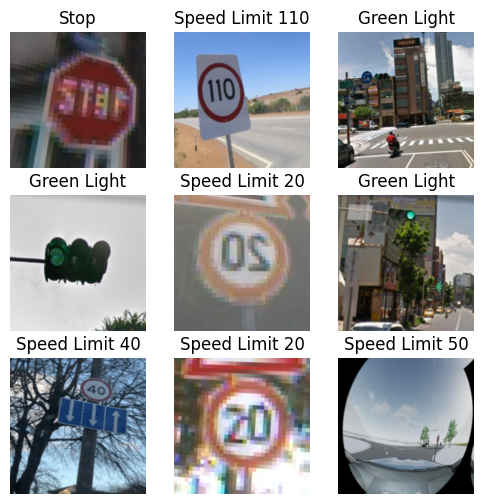

In [23]:
dls.show_batch(max_n=9, figsize=(6,6))

In [24]:
print(dls.vocab)
dblock.summary(path)

['Green Light', 'Red Light', 'Speed Limit 10', 'Speed Limit 100', 'Speed Limit 110', 'Speed Limit 120', 'Speed Limit 20', 'Speed Limit 30', 'Speed Limit 40', 'Speed Limit 50', 'Speed Limit 60', 'Speed Limit 70', 'Speed Limit 80', 'Speed Limit 90', 'Stop']
Setting-up type transforms pipelines
Found 4965 items
2 datasets of sizes 3972,993
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /content/car/data/Speed Limit 100/train_00007_00013_00025_png.rf.0df59172b135e8793dc48f3b0ad12e5f.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=416x416
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /content/car/data/Speed Limit 100/train_00007_00013_00025_png.rf.0df59172b135e8793dc48f3b0ad12e5f.jpg
    applying parent_label gives
      Speed Limit 100
    applying 

# A.4: Train a simple model

In [25]:
learn18 = vision_learner(dls, resnet18, metrics=accuracy)
learn18.fine_tune(3)

epoch,train_loss,valid_loss,accuracy,time
0,2.821633,1.661124,0.498489,00:29


epoch,train_loss,valid_loss,accuracy,time
0,1.635934,1.237948,0.611279,00:27
1,1.178492,0.935629,0.707956,00:26
2,0.863583,0.861031,0.726083,00:26


In [29]:
learn1 = vision_learner(dls, resnet18, metrics=accuracy)
learn1.fine_tune(15)

epoch,train_loss,valid_loss,accuracy,time
0,3.208275,1.944765,0.449438,00:17


epoch,train_loss,valid_loss,accuracy,time
0,2.348105,1.629896,0.493134,00:18
1,2.079337,1.478470,0.531835,00:17
2,1.848953,1.342055,0.556804,00:17
3,1.590299,1.233073,0.596754,00:16
4,1.325716,1.188039,0.627965,00:17
5,1.146457,1.073186,0.660424,00:18
6,0.999277,1.072143,0.664170,00:16
7,0.870192,1.047008,0.677903,00:16
8,0.755685,1.004303,0.695381,00:16
9,0.657944,1.001723,0.716604,00:19


In [26]:
learn34 = vision_learner(dls, resnet34, metrics=accuracy)
learn34.fine_tune(3)

epoch,train_loss,valid_loss,accuracy,time
0,2.768913,1.576485,0.490433,00:26


epoch,train_loss,valid_loss,accuracy,time
0,1.567444,1.123890,0.647533,00:31
1,1.099315,0.781155,0.765357,00:29
2,0.724342,0.714991,0.775428,00:28


In [28]:
learn3 = vision_learner(dls, resnet34, metrics=accuracy)
learn3.fine_tune(15)

epoch,train_loss,valid_loss,accuracy,time
0,2.825311,1.668363,0.497482,00:27


epoch,train_loss,valid_loss,accuracy,time
0,1.633766,1.214693,0.612286,00:29
1,1.268567,0.980551,0.670695,00:29
2,0.956897,0.914120,0.736153,00:30
3,0.754540,0.816502,0.751259,00:30
4,0.592523,0.715479,0.787513,00:30
5,0.464458,0.734384,0.788520,00:29
6,0.374304,0.669387,0.818731,00:29
7,0.310485,0.623337,0.836858,00:29
8,0.244058,0.635064,0.826788,00:29
9,0.197122,0.627626,0.829809,00:29


In [27]:
learn50 = vision_learner(dls, resnet50, metrics=accuracy)
learn50.fine_tune(epochs= 3)

epoch,train_loss,valid_loss,accuracy,time
0,2.707162,1.733325,0.502518,00:36


epoch,train_loss,valid_loss,accuracy,time
0,1.524273,1.256600,0.626385,00:45
1,1.145324,0.948480,0.703928,00:45
2,0.802425,0.880900,0.730111,00:47


In [29]:
interp = ClassificationInterpretation.from_learner(learn3)

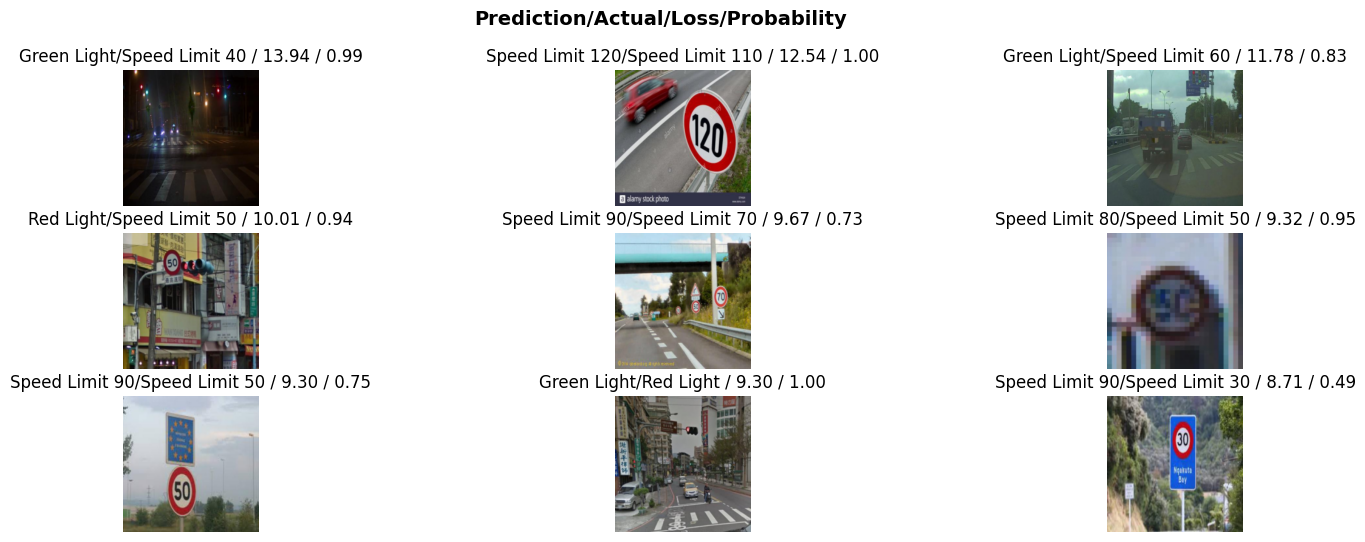

In [30]:
interp.plot_top_losses(9, figsize=(18,6))

Since there are multiple signs or lights in some images, the actual accuracy should be higher and the validation loss should be a lot lower than the one portrayed.

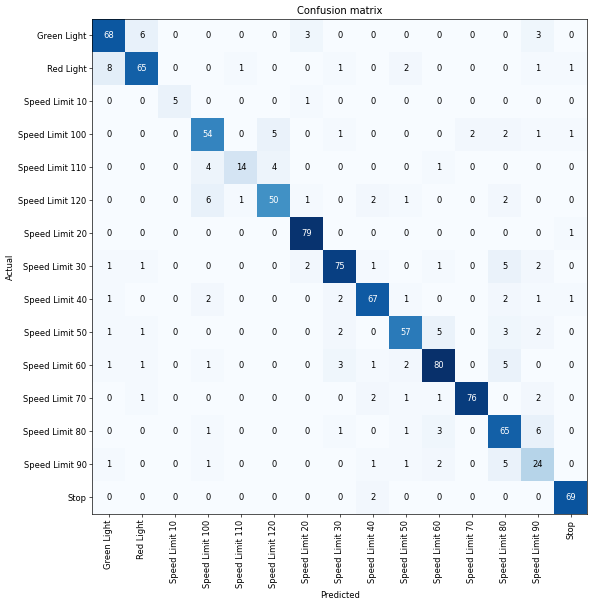

In [31]:
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)

#B.1-2

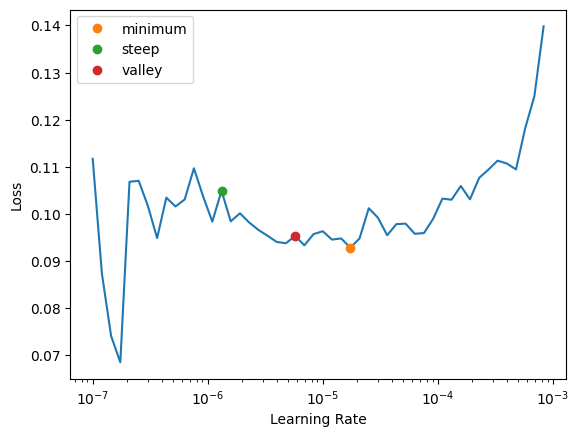

In [32]:
lr_min, lr_steep, lr_valley = learn3.lr_find(suggest_funcs=(minimum, steep, valley))

In [37]:
lr_min, lr_steep, lr_valley

(1.737800812406931e-06, 1.3182567499825382e-06, 5.754399353463668e-06)

In [33]:
learn3.summary()

Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                      

In [39]:
learn3.export("/content/model/resnet34-15epoch.pkl")

# B.3-4-5

In [49]:
learn4 = learn3

In [50]:
learn4.dls = dls

In [51]:
learn4.freeze()

epoch,train_loss,valid_loss,accuracy,time
0,0.191931,0.664449,0.837865,00:28
1,0.188150,0.656855,0.836858,00:27
2,0.187883,0.655957,0.835851,00:27
3,0.201885,0.656873,0.838872,00:27


In [58]:
learn4.fit_one_cycle(20, lr_max=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.073783,0.600647,0.867069,00:28
1,0.076991,0.594521,0.873112,00:29
2,0.080254,0.594921,0.872105,00:29
3,0.077445,0.600214,0.867069,00:29
4,0.081528,0.606984,0.863041,00:28
5,0.074626,0.610820,0.871098,00:29
6,0.072693,0.622640,0.868077,00:29
7,0.079030,0.612105,0.871098,00:29
8,0.074882,0.635279,0.869084,00:29
9,0.071865,0.637157,0.869084,00:29


In [54]:
learn4.unfreeze()

In [59]:
interp = ClassificationInterpretation.from_learner(learn4)

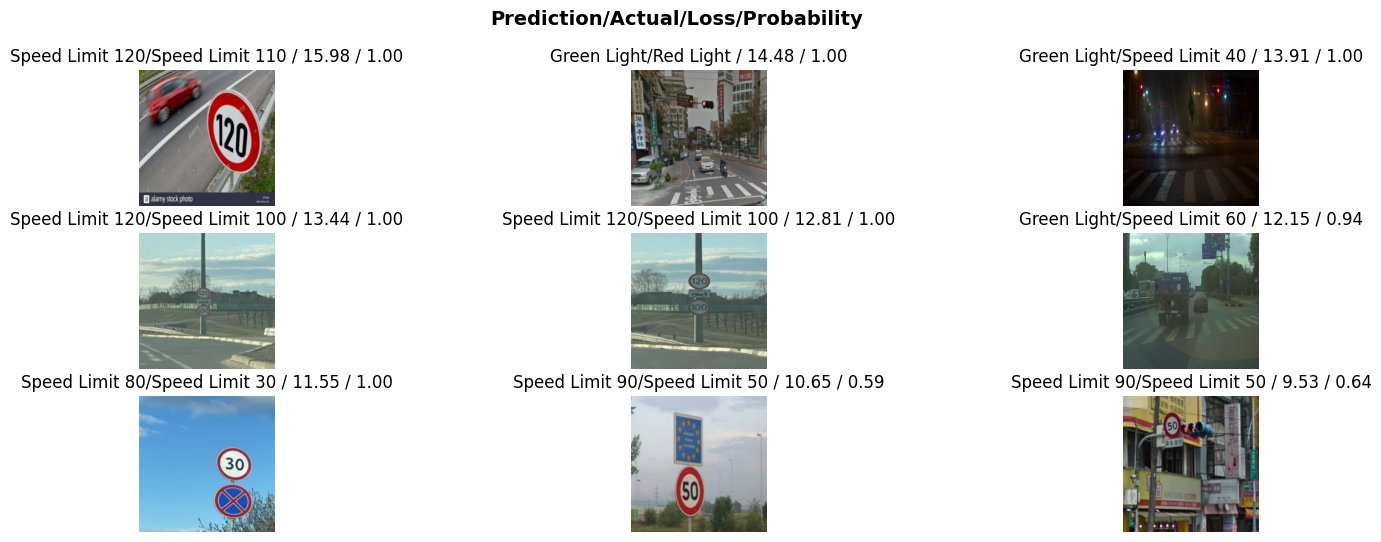

In [60]:
interp.plot_top_losses(9, figsize=(18,6))

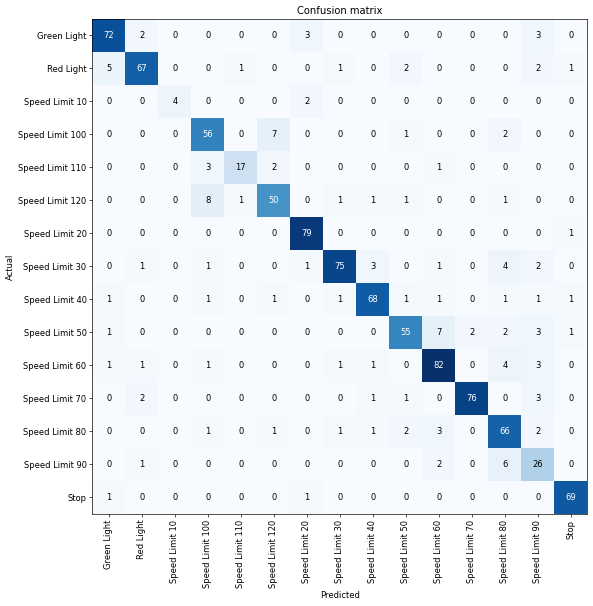

In [61]:
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)

# B.6

In [62]:
dls = dblock.dataloaders(path, bs= 16)

In [63]:
learn4.dls = dls

In [64]:
learn4.fit_one_cycle(4, lr_max=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.114175,0.680318,0.867069,00:38
1,0.111536,0.712939,0.864048,00:36
2,0.100625,0.710016,0.867069,00:39
3,0.096089,0.695824,0.872105,00:38


In [65]:
interp = ClassificationInterpretation.from_learner(learn4)

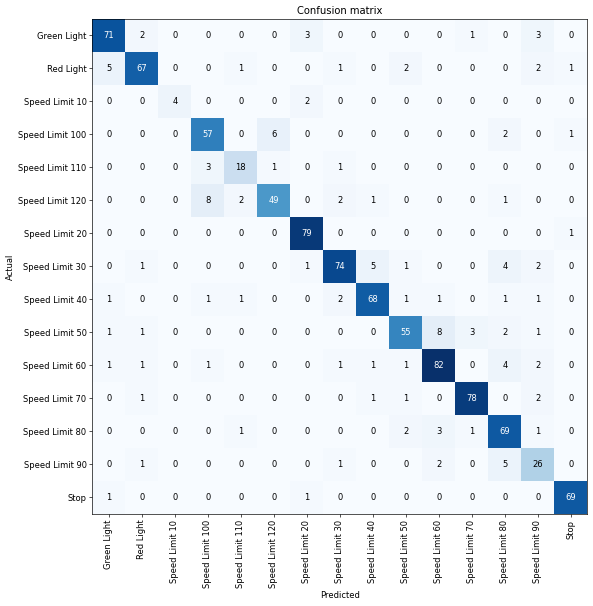

In [66]:
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)

In [67]:
learn3.export("/content/model/resnet34-learn4.pkl")

In [79]:
import PIL
import gradio as gr

learn = load_learner('/content/model/resnet34-learn4.pkl')

def predict(img):
    if not isinstance(img, PIL.Image.Image):
        img = PILImage.create(img)
        img = img.resize((224, 224))
    pred_class, pred_idx, probs = learn.predict(img)
    class_names = learn.dls.vocab
    confidence = probs[pred_idx].item()
    threshold = 0.96
    if confidence < threshold:
        return {"Image is predicted to be irrelevant."}
    return {
        "predicted_class": str(pred_class),
        "confidence": round(probs[pred_idx].item(), 4),
        "all_probabilities": {
            str(cls): round(probs[i].item(), 4)
            for i, cls in enumerate(class_names)
        }
    }

demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=gr.JSON(),
    title="Traffic Sign and Light Recognition",
    description="."
)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [80]:
demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://b3bfaa46880631f2ec.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
